# Transfer learning for COVID-19 diagnosis using CT images.
A 2D CNN for COVID-19 diagnosis using CT images will be developed.
The CNN will be implemented usign PyTorch and will be based on ResNet-18.
The CNN will be trained using transfer learning and compared to a model trained from scratch.

Loading the required packages.

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as tv_models
import skimage
import skimage.io as io
import glob

Fixing the random seeds so the results are more reproducible.

In [2]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(0)

Defining the dataset class.

In [3]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label

Building the dataloaders.
Mini-batch size = 32.

In [4]:
def get_dataloader_train():
    df_train=pd.read_csv('S224/train.csv')
    path='S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    return loader_train

In [5]:
def get_dataloader_val():
    df_val=pd.read_csv('S224/val.csv')
    path='S224/'
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0,
                                    shuffle=False, pin_memory=True)
    return loader_val

In [6]:
def get_dataloader_test():
    df_test=pd.read_csv('S224/test.csv')
    path='S224/'
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0,
                                    shuffle=False, pin_memory=True)
    return loader_test

In [7]:
loader_train = get_dataloader_train()
loader_val = get_dataloader_val()
loader_test = get_dataloader_test()

Importing the data.

In [8]:
path='S224/'
df_train=pd.read_csv('S224/train.csv')
dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
df_val=pd.read_csv('S224/val.csv')
dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values)
df_test=pd.read_csv('S224/test.csv')
dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)

In [9]:
len(dataset_train)

2022

In [10]:
len(loader_train)

64

In [11]:
len(dataset_val)

60

In [12]:
len(loader_val)

2

In [13]:
len(dataset_test)

400

In [14]:
len(loader_test)

13

In [15]:
dataset_train[0][0].shape

/var/folders/vw/2bv9tkmd5y7cnd8h_r6t6sj40000gn/T/ipykernel_58770/4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


torch.Size([3, 224, 224])

Checking class imbalance.

<AxesSubplot:>

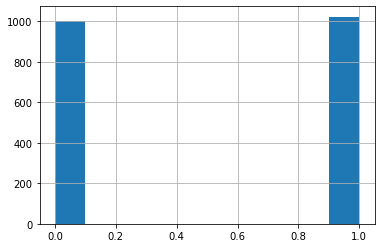

In [16]:
df_train['label'].hist()

<AxesSubplot:>

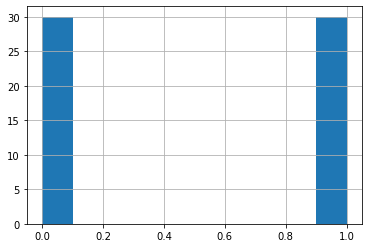

In [17]:
df_val['label'].hist()

<AxesSubplot:>

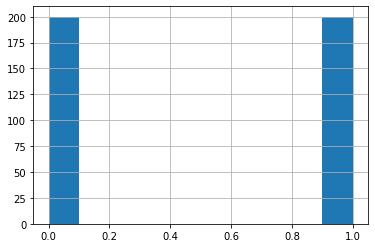

In [18]:
df_test['label'].hist()

The classes are balanced.

Showing some of the images.

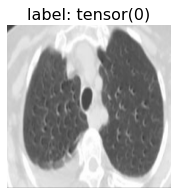

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 6, 1):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(2.5)  

Defining a function to save the models.

In [20]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

Building the function to train the model in one epoch.

In [21]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#setting model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Z = model(X)
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

Building the function to test the model.

In [22]:
def test(model, device, dataloader):
    model.eval()#setting model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum()
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

Defining a function to show the results.

In [23]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

## Defining the CNN

Here is the structure of the original ResNet-18 model.

In [16]:
resnet18 = tv_models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Defining the CNN based on ResNet-18 using the pretrained model
The parameters in the first layers are frozen and only the ones in layer 4 and the last layer are optimized.
The last layer is modified to do binary classification from 512 input features.
The model was pretrained on ImageNet.

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        self.resnet18 = tv_models.resnet18(pretrained=True) 
        #modifying the last layer
        self.resnet18.fc=torch.nn.Linear(512, 1)           
        #freezing all the parameters
        for p in self.resnet18.parameters():
            p.requires_grad = False 
        #setting the parameters of layer4 to be trainable       
        for p in self.resnet18.layer4.parameters():
            p.requires_grad = True       
        #setting the parameters of the last layer to be trainable       
        for p in self.resnet18.fc.parameters():
            p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet18.layer4.parameters())+list(self.resnet18.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet18(x)
        z = z.view(-1)
        return z

## Creating the first CNN.

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

To modify the learning rate.

In [64]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

## Training-validation
The model is trained for 50 epochs.
The loss and accuracy are displayed during training.

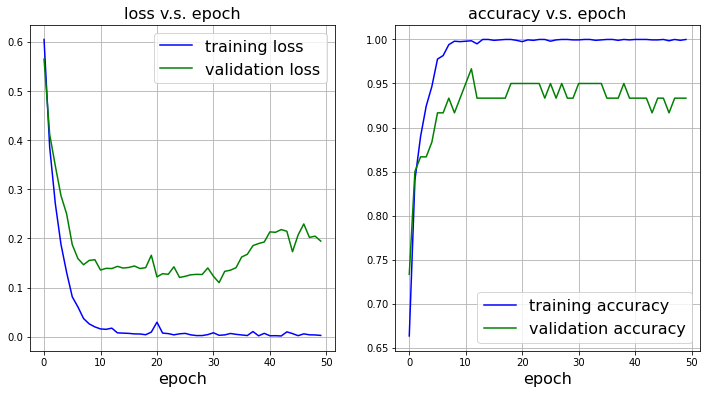

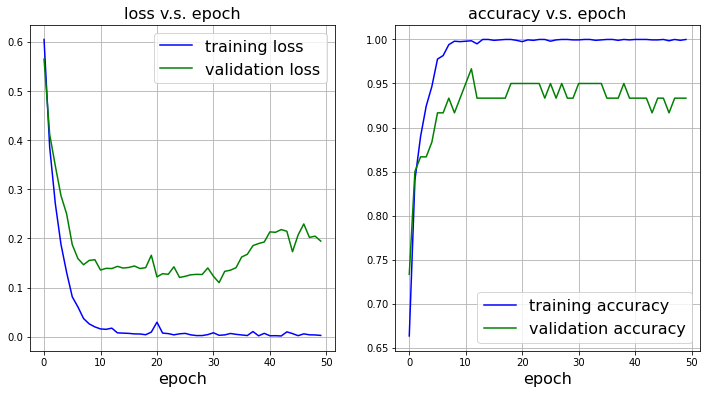

In [65]:
for epoch in range(epoch_save+1, 50):
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch_pretrained_'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

## Testing the model.

Finding the best model using the validation accuracy.

In [66]:
best_model= np.array(acc_val_list).argmax()
best_model

11

Loading the best model.

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch_pretrained_'+str(best_model)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']  

Testing the best model.

In [68]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

/var/folders/vw/2bv9tkmd5y7cnd8h_r6t6sj40000gn/T/ipykernel_58770/4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.9475
Accuracy (average) 0.9475
Sensitivity [0.935 0.96 ]
Precision [0.95897436 0.93658537]
Confusion_sens 
 [[0.935 0.065]
 [0.04  0.96 ]]
Confusion_prec 
 [[0.95897436 0.06341463]
 [0.04102564 0.93658537]]


## Visualization

Visualization can give us some intuitive understanding of how the CNN is working.

Visualizing the kernels of the first convolution layer. This layer was not trained in this model. The weights have some geometrical paterns that seem object oriented.

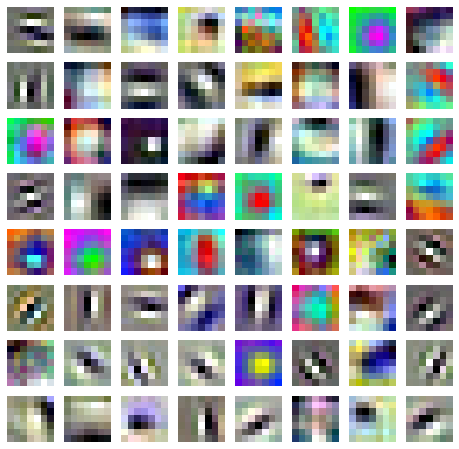

In [69]:
w=model.resnet18.conv1.weight.detach().cpu().numpy()
fig, ax = plt.subplots(8,8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    I = w[i,:,:,:]
    I = I.transpose(1,2,0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    axi.imshow(I)
    axi.axis('off')

Visualizing the gradient of loss with respect to input. In this application in particular it is interesting to visualize which are the parts of the image that have more influence on the estimated output, the diagnosis.

In [47]:
def normalize_color_image(I):
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    return I

/var/folders/vw/2bv9tkmd5y7cnd8h_r6t6sj40000gn/T/ipykernel_58770/4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Text(0.5, 1.0, 'abs(dL/dx)')

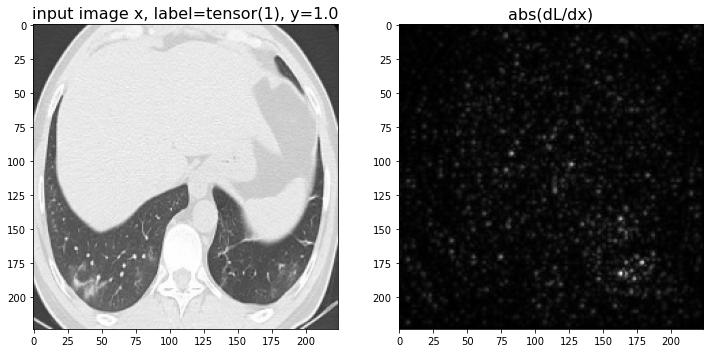

In [75]:
(x,label)=dataset_test[-7]
x=x.view(1,3,224,224).to(device)
x.requires_grad=True
z=model(x)
y=torch.tensor([label], dtype=x.dtype, device=device)
loss = nnF.binary_cross_entropy_with_logits(z, y)
loss.backward()
#--------------------------------------------------
y=y.item()
xx = x.detach().cpu().numpy().squeeze()
xx=xx.transpose(1,2,0)
x_grad=x.grad.data.detach().cpu().numpy().squeeze()
x_grad=x_grad.transpose(1,2,0)
x_grad=np.abs(x_grad).sum(axis=2)
xx = normalize_color_image(xx)
#--------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(xx)
ax[0].set_title('input image x, label='+str(label)+', y='+str(y), fontsize=16)
ax[1].imshow(x_grad, cmap='gray', vmin=x_grad.min(), vmax=x_grad.max())
ax[1].set_title('abs(dL/dx)', fontsize=16)

## Defining the CNN based on ResNet-18 and training it from scratch.
This time the model was not pretrained on another dataset and all the parameters will be trained using the training dataset.

In [38]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()        
        self.resnet18 = tv_models.resnet18(pretrained=False)
        #modifying the last layer for binary classification  
        self.resnet18.fc=torch.nn.Linear(512, 1)           
        # this time no parameters are frozen       
        
    def forward(self,x):
        z = self.resnet18(x)
        z = z.view(-1)
        return z

## Creating the CNN that is no pretrained.

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net1()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99) 
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

To modify the learning rate.

In [40]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

## Training-validation
The model is trained for 50 epochs.
The loss and accuracy are displayed during training.

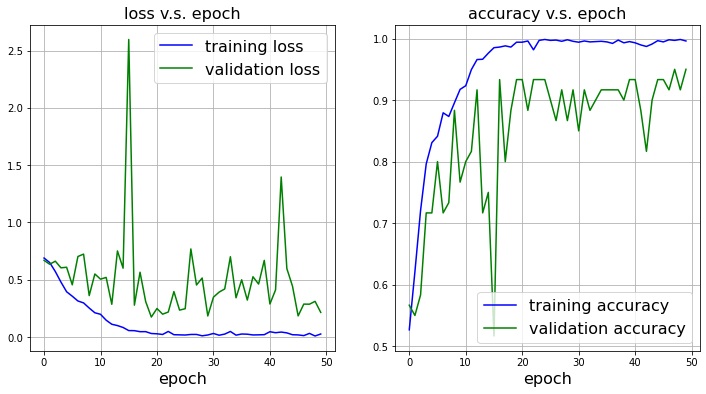

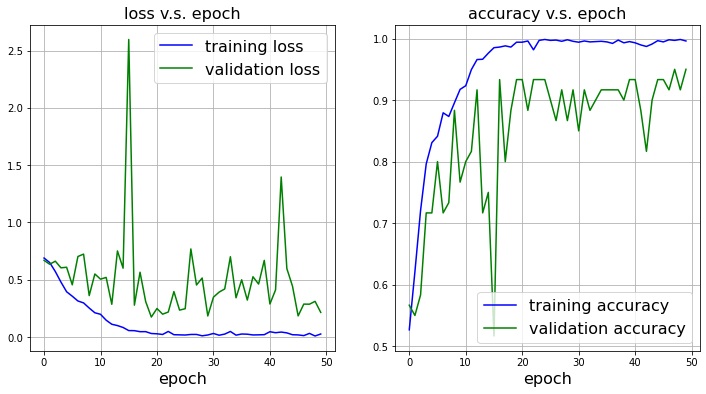

In [41]:
for epoch in range(epoch_save+1, 50):
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

## Testing the model

Finding the best model using the validation accuracy.

In [42]:
best_model= np.array(acc_val_list).argmax()
best_model

47

Loading the best model.

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch'+str(best_model)+'.pt', map_location=device)
model=Net1()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']  

Testing the best model

In [44]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

/var/folders/vw/2bv9tkmd5y7cnd8h_r6t6sj40000gn/T/ipykernel_58770/4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.9275
Accuracy (average) 0.9275
Sensitivity [0.895 0.96 ]
Precision [0.95721925 0.90140845]
Confusion_sens 
 [[0.895 0.105]
 [0.04  0.96 ]]
Confusion_prec 
 [[0.95721925 0.09859155]
 [0.04278075 0.90140845]]


## Visualization

Visualizing the kernels of the first convolution layer. In this case this layer was trained on the current dataset. The weights are different to ones of the pretrained model. There are no strong recongizable patterns.

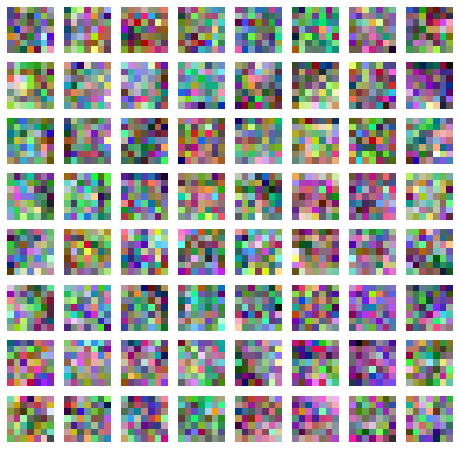

In [45]:
w=model.resnet18.conv1.weight.detach().cpu().numpy()
fig, ax = plt.subplots(8,8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    I = w[i,:,:,:]
    I = I.transpose(1,2,0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    axi.imshow(I)
    axi.axis('off')

Visualizing the gradient of loss with respect to input. This time the parts of the image which correspond to the lungs seem to have more influence. They are more strongly highlited in the gradient of the loss plot.

/var/folders/vw/2bv9tkmd5y7cnd8h_r6t6sj40000gn/T/ipykernel_58770/4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Text(0.5, 1.0, 'abs(dL/dx)')

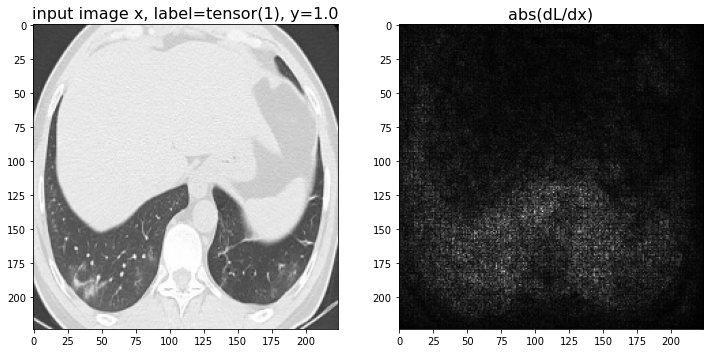

In [61]:
(x,label)=dataset_test[-7]
x=x.view(1,3,224,224).to(device)
x.requires_grad=True
z=model(x)
y=torch.tensor([label], dtype=x.dtype, device=device)
loss = nnF.binary_cross_entropy_with_logits(z, y)
loss.backward()
#--------------------------------------------------
y=y.item()
xx = x.detach().cpu().numpy().squeeze()
xx=xx.transpose(1,2,0)
x_grad=x.grad.data.detach().cpu().numpy().squeeze()
x_grad=x_grad.transpose(1,2,0)
x_grad=np.abs(x_grad).sum(axis=2)
xx = normalize_color_image(xx)
#--------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(xx)
ax[0].set_title('input image x, label='+str(label)+', y='+str(y), fontsize=16)
ax[1].imshow(x_grad, cmap='gray', vmin=x_grad.min(), vmax=x_grad.max())
ax[1].set_title('abs(dL/dx)', fontsize=16)

## Comments
As it can be seen, the results between the two models do not differ much. The accuracy, sensitivity and precision on the test set are higher than 0.9 for both of them. Transfer learning does not seem to have a great contribution to the model. There are some reasons that could explain this.
First, ResNet-18 was pretrained on ImageNet, which is a databased not based on CT images. Therefore, the image patterns might not be similar to the ones in the current dataset.
Secondly, although transfer learning can be useful when the model is pretrained on a larger dataset and then optimized in the smaller dataset, that does not seem to be the case here. The current dataset has around a 1000 samples in both classes, which does not seem very small and might be enough to train the model from scratch. 
On the other hand, transfer learning did reduce the computational cost of training the model, mainly because less parameters had to be trained in every epoch.
For these reasons, transfer learning might not bring a lot of benefits in this case. Besides the decrease in the computational cost there was only a slight change in the model overall performance.